In [1]:
import pandas as pd
import numpy as np
import glob
import torch
import torch.nn as nn
from torch.autograd import Variable

In [2]:
# pd.read_csv made some mistakes when reading the tsv files
# this function is able to read the files more reliably
def read_csv(path, sep= ',', names=["PAGENAME", "OCR", "GT"]):
    with open(path, 'r', encoding='utf8') as file:
        rows = file.read().split("\n")
        data = np.array([row.split(sep) for row in rows if len(row.split(sep)) == 3])
    return pd.DataFrame(data=data, columns=names)

In [3]:
ocr_file_0 = "../ocr_data/nlf_ocr_gt_tescomb5_2017.xlsx"
path = '../ocr_data/'
folders = [f for f in glob.glob(path + "**/*.tsv", recursive=True)] 

In [4]:
df_sampled = pd.concat([read_csv(path, sep = "\t", names=["PAGENAME", "OCR", "GT"]) for path in folders])

In [5]:
# reading the excel file takes a while
df_full = pd.read_excel(ocr_file_0, sheet_name="Words", header=3, skip_rows=[0,1,2])

In [6]:
ground_truth = df_full.values[:,5].astype(np.str)
ocr_tess = df_full.values[:,6].astype(np.str)
ocr_old = df_full.values[:,7].astype(np.str)
ocr_fr11 = df_full.values[:,8].astype(np.str)
ocr_sampled = df_sampled.values[:,1].astype(np.str)
ocr_sampled_gt = df_sampled.values[:,2].astype(np.str)

In [7]:
# join the individual words into pages
def join(array):
    return " ".join(map(str, array))
def combine_to_pages(dataframe, column):
    pages = np.split(dataframe.values[:, column], np.cumsum(np.unique(dataframe.values[:, 3], return_counts=True)[1])[:-1])
    return np.array(list(map(join, pages)))
pages_gt = combine_to_pages(df_full, 5)
pages_tess = combine_to_pages(df_full, 6)
pages_old = combine_to_pages(df_full, 7)
pages_fr11 = combine_to_pages(df_full, 8)
ocr_sampled = df_sampled.values[:,1]
pages_gt[1][:140]

'että kunnille sallittaisiin walta sulkea kapakat alueellaan, mutta wielä ei ole semmoinen laki tullut toimeen. Parlamentti on tosin kerran h'

In [8]:
def levenshteinDistance(s1, s2):
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1] #/ (1.0*len(s2))  
vectorLehvenstein = np.vectorize(levenshteinDistance)

In [9]:
lehv_tess = vectorLehvenstein(ocr_tess, ground_truth)
lehv_old = vectorLehvenstein(ocr_old, ground_truth)
lehv_fr11 = vectorLehvenstein(ocr_fr11, ground_truth)
lehv_sampled = vectorLehvenstein(ocr_sampled, ocr_sampled_gt)
print(np.mean(lehv_tess))

0.7084911313518696


In [10]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.LSTM(hidden_size, hidden_size, n_layers)#nn.GRU(hidden_size, hidden_size, n_layers)#
        self.decoder = nn.Linear(hidden_size, output_size)
        self.sig = nn.Sigmoid()
    
    def forward(self, input, hidden):
        #print(input)
        input = self.encoder(input.view(1, -1))
        #print(input)
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        #print(output)
        output = self.decoder(output.view(1, -1))
        #print(output)
        output = self.sig(output)
        return output, hidden

    def init_hidden(self):
        return (Variable(torch.zeros(self.n_layers, 1, self.hidden_size)),
                Variable(torch.zeros(self.n_layers, 1, self.hidden_size)))#
        #return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

In [11]:
all_characters = sorted(list(set(" ".join(np.concatenate([ground_truth,ocr_tess,ocr_old,ocr_fr11,ocr_sampled,ocr_sampled_gt])))))
n_characters = len(all_characters)

def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(all_characters, len(all_characters))
print(char_tensor('all_characters'))

[' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\x84', '¡', '£', '¦', '§', '©', '«', '®', '°', '²', '³', '´', '¹', 'º', '»', '¼', '½', '¾', 'À', 'Ä', 'Å', 'É', 'Ö', '×', 'Ü', 'ß', 'à', 'á', 'â', 'ã', 'ä', 'å', 'æ', 'ç', 'è', 'é', 'ë', 'ì', 'ï', 'ò', 'ó', 'ô', 'õ', 'ö', 'ø', 'ú', 'ü', 'Ā', 'ă', 'ė', 'Ő', 'ő', 'œ', 'š', 'ȧ', 'ʃ', '˝', 'ˮ', '˶', '˷', '̋', 'β', 'ε', 'λ', 'А', 'В', 'Г', 'Е', 'З', 'И', 'Й', 'К', 'Л', 'М', 'Н', 'О', 'П', 'Р', 'С', 'Т', 'У', 'Ф', 'Ц', 'Ч', 'Ъ', 'Ы', 'Ь', 'Ю', 'Я', 'а', 'б', 'в', 'г', 'д', 'е', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 

In [12]:
def estimate_accuracy(estimator, ocr):
    res = []
    for item in ocr:
        hidden = estimator.init_hidden()
        item_output = []
        for char in char_tensor(item):
            output, hidden = estimator(char, hidden)
            item_output.append(output.detach().numpy()[0])
        res.append(np.array(item_output))
    return np.array(res)
def estimate_quality(estimator, ocr):
    item_acc = 0
    char_acc = 0
    word_acc = 0
    char_len = 0
    word_len = 0
    for item in ocr:
        char_len += len(item)
        word_len += 1
        hidden = estimator.init_hidden()
        tmp_item_acc = 0
        tmp_item_err = 0
        tmp_word_err = 0
        for char in char_tensor(item):
            if(char == char_tensor(" ")[0]):
                word_acc += 1 - np.min([tmp_word_err, 1])
                tmp_word_err = 0
                word_len += 1
            output, hidden = estimator(char, hidden)
            tmp = (output.detach().numpy()[0] >= 0.5) * 1 #(np.argmax(output.detach().numpy().squeeze(0))==0)*1
            tmp_item_acc += tmp
            tmp_item_err += 1 - tmp
            tmp_word_err += 1 - tmp
        char_acc += tmp_item_acc
        item_acc += 1 - np.min([tmp_item_err, 1])
        word_acc += 1 - np.min([tmp_word_err, 1])
            
    item_acc = item_acc/len(ocr)
    word_acc = word_acc/max(word_len, 1)
    char_acc = char_acc/max(char_len, 1)
    return (item_acc, word_acc, char_acc)
            

In [13]:
def lehvenstein_differences(ocr, truth):
    #compute lehvenstein stuff but return an array of
    # 1,x,x,x if correct letter
    # x,1,x,x if different letter
    # x,x,1,x if missing letter
    # x,x,x,1 if extra letter
    m = len(ocr)
    n = len(truth)
    d = np.zeros([n+1, m+1], np.int)
    path = np.zeros([n+1, m+1], np.int)
    path[0,0] = 2
    for i in range(1, n+1):
        d[i, 0] = i
        path[i, 0] = 1
    for j in range(1, m+1):
        d[0, j] = j
        path[0, j] = 0
    for j in range(1, m+1):
        for i in range(1, n+1):
            substitutionCost = 1-(truth[i-1] == ocr[j-1])*1
            choices = [ d[i-1, j] + 1,                   # deletion
                        d[i, j-1] + 1,                   # insertion
                        d[i-1, j-1] + substitutionCost]  # substitution
            min_choice = np.argmin(choices)
            
            path[i, j] = min_choice
            d[i, j] = choices[min_choice]
    i = n
    res = np.zeros([m+1, 4], np.int)
    for j in range(m, -1, -1):
        prev = -1
        while prev <= 0:
            prev = path[i, j]
            #print(truth[i-1] , ocr[j-1], i, j, prev)
            if prev == 0: #deletion
                i -= 1
                res[j, 3] = 1
            elif prev == 1: #insertion
                res[j, 2] = 1
            elif prev == 2: #substitution
                if (i<=0 or truth[i-1] == ocr[j-1]):
                    if res[j, 3]==0:
                        res[j, 0] = 1 # correct
                else:
                    res[j, 1] = 1 # wrong character
                i -= 1
    return res[:,0]
def vector_differences(ocr, gt): #np.vectorize(lehvenstein_differences, signature='()->(n)')
    assert(len(ocr)==len(gt))
    return np.array([lehvenstein_differences(ocr[i], gt[i]) for i in range(len(ocr))])

In [14]:
# compute the training targets on character level
target_old = vector_differences(ocr_old, ground_truth)
target_old[0], ocr_old[0], ground_truth[0]

(array([1, 0, 1, 0, 0]), 'M:c>', 'N:o')

In [15]:
training_data = " "+" ".join(ocr_old)
target_data = torch.Tensor(np.concatenate(target_old).astype(np.long))
chunk_len = 400
data_len = int(len(training_data)*0.8)

def random_chunk():
    start_index = np.random.randint(0, data_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return (training_data[start_index:end_index], target_data[start_index:end_index])

print(data_len)
print(target_data.shape)
print(training_data[:10])
print(target_data[:10])
#print(random_chunk())

3124681
torch.Size([3905852])
 M:c> 0. t
tensor([1., 0., 1., 0., 0., 1., 1., 1., 1., 1.])


In [16]:
def random_training_set():    
    chunk, target = random_chunk()
    inp = char_tensor(chunk)
    add_noise = 0.5
    if(np.random.random() < add_noise):
        noise_level = np.random.random() * 0.5
        for i in range(len(chunk)):
            if(np.random.random()<add_noise):
                old = inp[i]
                inp[i] = np.random.randint(0, n_characters)
                #if (inp[i] != old):
                target[i] = 0
    #target = target_data[chunk]
    return inp, Variable(target)

In [17]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [18]:
def train(inp, target, model, optimizer):
    chunk_len = len(inp)
    hidden = model.init_hidden()
    model.zero_grad()
    loss = Variable(torch.Tensor(1))
    
    for c in range(chunk_len):
        output, hidden = model(inp[c], hidden)
        tmploss = criterion(output, target[c].unsqueeze(0).unsqueeze(0)) #criterion expects a batch dimension, so unsqueeze one
        if(tmploss < 0 or tmploss > 10):
            print(output, target[c].unsqueeze(0), tmploss)
        loss += tmploss
    #loss = criterion(output, torch.Tensor(np.array(target.mean())).unsqueeze(0).unsqueeze(0))

    loss.backward()
    optimizer.step()

    return loss.item() / chunk_len

In [19]:
n_epochs = 1000
print_every = 100
plot_every = 10
hidden_size = 100
target_size = 1
n_layers = 2
lr = 0.005

ocr_estimator = RNN(n_characters, hidden_size, target_size, n_layers)
ocr_optimizer = torch.optim.Adam(ocr_estimator.parameters(), lr=lr)
criterion = nn.BCELoss()#nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    with torch.enable_grad():
        loss = train(*random_training_set(), ocr_estimator, ocr_optimizer)       
        loss_avg += loss

        if epoch % print_every == 0:
            print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))

        if epoch % plot_every == 0:
            all_losses.append(loss_avg / plot_every)
            loss_avg = 0

 20s (100 10%) 0.2970]
 41s (200 20%) 0.3089]
 1s (300 30%) 0.3162]
 22s (400 40%) 0.3290]
 42s (500 50%) 0.1643]
 2s (600 60%) 0.1455]
 23s (700 70%) 0.0993]
 44s (800 80%) 0.2392]
 5s (900 90%) 0.2412]
 26s (1000 100%) 1.3410]


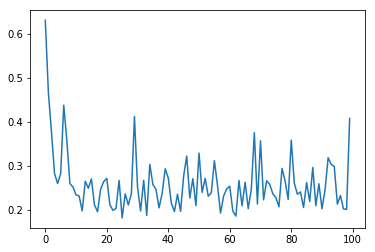

In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [21]:
estimate_quality(ocr_estimator, ocr_sampled)

(array([0.04631241]), array([0.45531924]), array([0.87828294]))

In [22]:
#check accuracy on unseen part of text from the same ocr engine as the training data
estimate_quality(ocr_estimator, training_data[data_len+1:])

(array([0.95009025]), array([0.95575182]), array([0.95009025]))

In [ ]:
#training error, slow
estimate_quality(ocr_estimator, training_data[:data_len])

In [24]:
hidden = ocr_estimator.init_hidden()
char = char_tensor("ö")
output, hidden = ocr_estimator(char, hidden)
char = char_tensor("ü")
output, hidden = ocr_estimator(char, hidden)
output

tensor([[0.0071]], grad_fn=<SigmoidBackward>)